In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch
import pandas as pd
import os
from PIL import Image
import copy
from tqdm import tqdm
import pandas as pd

from torch.backends import cudnn
import torch
import torch.nn.functional as F
from torchvision import transforms as T

from utils import *

# Initialize detector and pose estimator

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cudnn.benchmark = True

import openpifpaf
pose_estimator, _ = openpifpaf.network.factory()
pose_estimator = pose_estimator.cuda()
decode = openpifpaf.decoder.factory_decode(pose_estimator,seed_threshold=0.3)
processor = openpifpaf.decoder.Processor(pose_estimator, decode, instance_threshold=0.05)

def get_boxes(img):     
    H,W,_ = img.shape
    data = openpifpaf.datasets.PilImageList([Image.fromarray(img)])
    loader = torch.utils.data.DataLoader(data, batch_size=1, pin_memory=True)

    images_batch = next(iter(loader))[0].cuda()
    fields_batch = processor.fields(images_batch)
    keypoint_sets, scores = processor.keypoint_sets(fields_batch[0])
    
    if not scores.any():
        return []
    
    ind = (np.max(keypoint_sets[:,:,1],axis=1)-np.min(keypoint_sets[:,:,1],axis=1))>0.15*H
    keypoint_sets = keypoint_sets[ind]
    scores = scores[ind]
    
    if not scores.any():
        return []
    
    x1 = np.min(keypoint_sets[:,[0,1,2,3,4,5,6,11,12],0],axis=1)
    x2 = np.max(keypoint_sets[:,[0,1,2,3,4,5,6,11,12],0],axis=1)
    y1 = np.min(keypoint_sets[:,[0,1,2,3,4,5,6,11,12],1],axis=1)
    y2 = np.max(keypoint_sets[:,[0,1,2,3,4,5,6,11,12],1],axis=1)
    w = x2-x1
    h = y2-y1

    x1 = x1-w*0.08
    x2 = x2+w*0.08
    y1 = y1-h*0.12
    
    x1[x1<0] = 0
    x2[x2>W] = W
    y1[y1<0] = 0
    y2[y2>H] = H
  
    boxes = np.stack([x1,y1,x2,y2,scores]).T
    boxes = nms(boxes,0.2)
    
    return boxes[:,:4]

# Obtaining 3D locations

In [3]:
Video = pd.read_pickle("./data/video_1.pkl", compression='zip')  

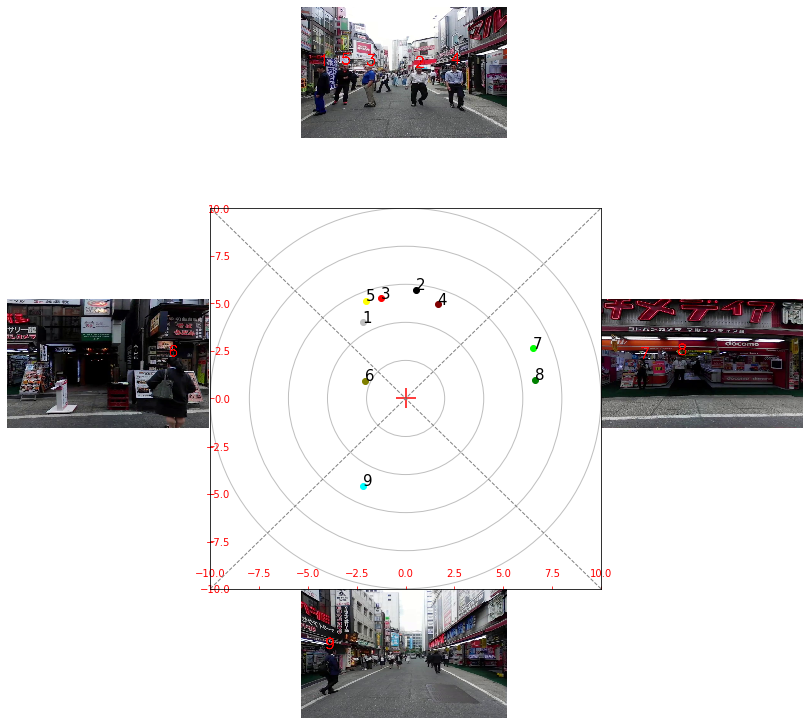

In [5]:
pano_detection = pd.Series()

for i,Images in enumerate(Video):

    Boxes = {}
    for k in Images:
        Boxes[k] = get_boxes(Images[k])
    
    Patches = {}
    for k in Boxes:
        if k in ['45','135','225','315']:
            corner = True
        else:
            corner = False 
        if len(Boxes[k])>0:
            Patches[k] = extract_image_patches(Images[k], Boxes[k], corner)    

    Locations = {}
    for k in Patches:
        Locations[k] = get_world_locations(Patches[k])
   
    pano_locations = get_pano_locations(Locations)
    
    pano_detection[str(i)] = pano_locations
    
    img_back_flip = copy.deepcopy(Images['back'][:,::-1,:])
    plot_pano(pano_locations, Images['front'], Images['left'], Images['right'], img_back_flip)

pano_detection.to_pickle("./data/pano_detection_1.pkl")

In [ ]:
Video = pd.read_pickle("./data/video_2.pkl", compression='zip')  

In [ ]:
pano_detection = pd.Series()

for i,Images in enumerate(Video):

    Boxes = {}
    for k in Images:
        Boxes[k] = get_boxes(Images[k])
    
    Patches = {}
    for k in Boxes:
        if k in ['45','135','225','315']:
            corner = True
        else:
            corner = False 
        if len(Boxes[k])>0:
            Patches[k] = extract_image_patches(Images[k], Boxes[k], corner)    

    Locations = {}
    for k in Patches:
        Locations[k] = get_world_locations(Patches[k])
   
    pano_locations = get_pano_locations(Locations)
    
    pano_detection[str(i)] = pano_locations
    
    img_back_flip = copy.deepcopy(Images['back'][:,::-1,:])
    plot_pano(pano_locations, Images['front'], Images['left'], Images['right'], img_back_flip)

pano_detection.to_pickle("./data/pano_detection_2.pkl")